In [1]:
import keras
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf

from matplotlib import pyplot as plt
from keras import applications
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten
from skimage import measure
from skimage.transform import resize

from utils import (
    draw_image, iou, map_iou, parse_dataset, get_dicom_fps, predict_submit
)
from utils.generator import DataGenerator

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
ROOT_DIR = os.path.abspath('..')
MODEL_DIR = os.path.join(ROOT_DIR, 'model')
RAWDATA_DIR = os.path.join(ROOT_DIR, 'data', 'raw')
PREPROCESS_DIR = os.path.join(ROOT_DIR, 'data', 'preprocess')
TRAIN_DICOM_DIR = os.path.join(RAWDATA_DIR, 'stage_1_train_images')
TEST_DICOM_DIR = os.path.join(RAWDATA_DIR, 'stage_1_test_images')

In [3]:
df_train = pd.read_csv(os.path.join(PREPROCESS_DIR, 'train.csv'))
train_patient_ids = sorted(list(df_train.patientId.unique()))

df_test = pd.read_csv(os.path.join(PREPROCESS_DIR, 'test.csv'))
test_patient_ids = list(df_test.patientId.unique())

In [4]:
random.seed(42)
random.shuffle(train_patient_ids)

validation_split = 0.1
split_index = int((1 - validation_split) * len(train_patient_ids))

patient_ids_train = train_patient_ids[:split_index]
patient_ids_validation = train_patient_ids[split_index:]

print(f'train len: {len(patient_ids_train)}\nvalidation len: {len(patient_ids_validation)}')

train len: 23115
validation len: 2569


In [5]:
def create_downsample(channels, inputs):
#     x = keras.layers.Activation('selu')(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
#     x = keras.layers.Activation('selu')(x)
    x = keras.layers.ELU()(x)
#     x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
#     x = keras.layers.Activation('selu')(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
#     x = keras.layers.Activation('selu')(inputs)
#     x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.ELU()(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
#     x = keras.layers.Activation('selu')(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
#     x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.ELU()(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)

    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)

    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
#     x = keras.layers.Activation('selu')(x)
#     x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.ELU()(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

def iou_bce_loss(y_true, y_pred):
    """ combine bce loss and iou loss
    """
    return .5 * keras.losses.binary_crossentropy(y_true, y_pred) + .5 * iou_loss(y_true, y_pred)


def mean_iou(y_true, y_pred):
    """ mean iou as a metric
    """
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

In [12]:
# keras.backend.get_session().run(tf.global_variables_initializer())
input_size = 256
channels = 32
depth = 4
n_blocks = 2
model = create_network(input_size=input_size, channels=channels, n_blocks=n_blocks, depth=depth)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

In [13]:
# https://github.com/keras-team/keras/issues/4623#issuecomment-269125127
keras.backend.get_session().run(tf.global_variables_initializer())
patience = 10
early_stopping = EarlyStopping(monitor='iou_bce_loss', mode='min', patience=patience)
input_shape = (input_size, input_size, 1)

generator_train = DataGenerator(
    TRAIN_DICOM_DIR,
    patient_ids_train,
    df_train,
    input_shape=input_shape,
    shuffle=True, augment=True, predict=False)
generator_validation = DataGenerator(
    TRAIN_DICOM_DIR,
    patient_ids_validation,
    df_train,
    input_shape=input_shape,
    shuffle=False, augment=False, predict=False)
history = model.fit_generator(
    generator_train,
    validation_data=generator_validation,
    callbacks=[learning_rate, early_stopping],
    epochs=25,
    workers=16,
    use_multiprocessing=True
)

Epoch 1/25


FailedPreconditionError: Attempting to use uninitialized value Adam_2/lr
	 [[Node: Adam_2/lr/_1848 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4_Adam_2/lr", _device="/job:localhost/replica:0/task:0/device:GPU:0"](Adam_2/lr)]]
	 [[Node: Adam_2/lr/_1849 = _Recv[_start_time=0, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4_Adam_2/lr", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Epoch 1/25


In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 256, 256, 32) 288         input_3[0][0]                    
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 256, 256, 32) 0           conv2d_45[0][0]                  
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 256, 256, 64) 2048        activation_9[0][0]               
__________________________________________________________________________________________________
max_poolin

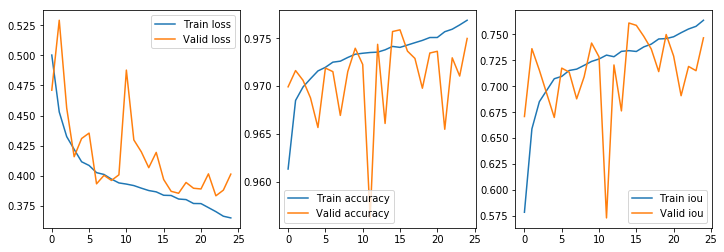

In [49]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [18]:
def get_bboxes(msk):
    bboxes = []
    comp = msk[:, :, 0] > 0.5
    
    # apply connected components
    comp = measure.label(comp)
    
    # apply bounding boxes
    for region in measure.regionprops(comp):
        y, x, y2, x2 = region.bbox
        w = x2 - x
        h = y2 - y
        bboxes.append([x, y, w, h])

    return bboxes

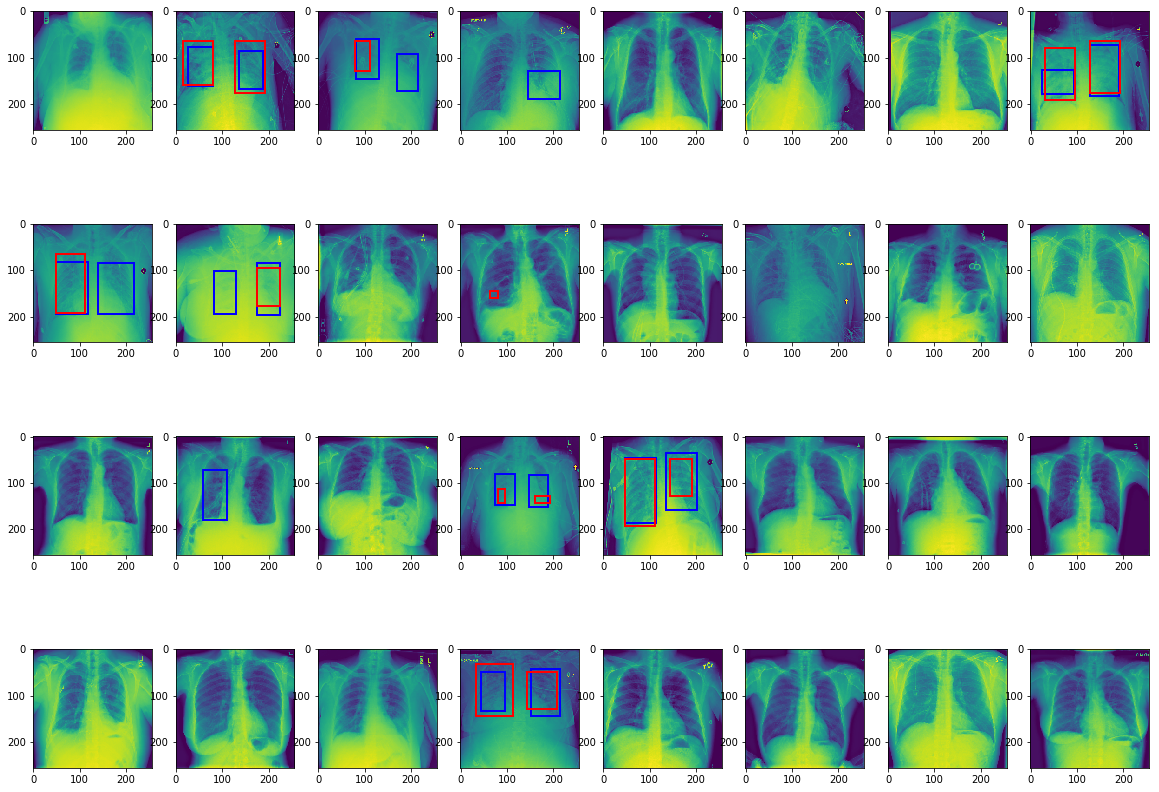

In [50]:
def _plot_bboxes(ax, bboxes, edgecolor):
    for bbox in bboxes:
        x, y, w, h = bbox
        ax.add_patch(patches.Rectangle(
            (x, y), w, h, linewidth=2, edgecolor=edgecolor, facecolor='none'
        ))

# will fetch one batch at a time
# only plot one batch
for imgs, msks in generator_validation:
    """
    imgs.shape: (32, 256, 256, 1)
    since batch_size is 32
    """
    # predict batch of images
    preds = model.predict(imgs)

    # create figure (4*8=32)
    f, ax_arr = plt.subplots(4, 8, figsize=(20,15))
    ax_arr = ax_arr.ravel()
    
    # loop through batch
    for ax, img, msk, pred in zip(ax_arr, imgs, msks, preds):
        # plot image
        ax.imshow(img[:, :, 0])

        true_bboxes = get_bboxes(msk)
        _plot_bboxes(ax, true_bboxes, 'b')

        # predicted mask
        pred_bboxes = get_bboxes(pred)
        _plot_bboxes(ax, pred_bboxes, 'r')

    plt.show()
    break

In [78]:
def map_iou(boxes_true, boxes_pred, thresholds=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    """
    Mean average precision at differnet intersection over union (IoU) threshold

    Args:
        boxes_true: Aarray of ground true bounding boxes of one image.
                    bbox format: (x1, y1, w, h)
        boxes_pred: Array of predicted bounding boxes of one image.
                    bbox format: (x1, y1, w, h)
        thresholds: IoU shresholds to evaluate mean average precision on

    Retruns:
        map: mean average precision of the image
    """

    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return None

    map_total = 0

    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = iou(bt, bp)
                if miou >= t \
                    and not matched \
                    and j not in matched_bt:
                    matched = True
                    # bt is matched for the first time, count as TP
                    tp += 1
                    matched_bt.add(j)
            if not matched:
                # bt has no match, count as FN
                fn += 1

        # FP is the bp that not matched to any bt
        fp = len(boxes_pred) - len(matched_bt)
        m = tp / (tp + fn + fp)
        map_total += m

    return map_total / len(thresholds)

b = 0
IoUs = []
total = int(np.ceil(len(patient_ids_validation)/32))
for imgs, msks in generator_validation:
# for imgs, msks in tqdm(generator_validation, total=total):
# for i in tqdm(range(total)):
    preds = model.predict(imgs)
    for img, msk, pred in zip(imgs, msks, preds):
        true_bboxes = get_bboxes(msk)
        pred_bboxes = get_bboxes(pred)
        
        _iou = map_iou(true_bboxes, pred_bboxes)
        if _iou is not None:
            IoUs.append(_iou)
    b += 1
    if b == total:
        break
print("- mIoUs:", np.mean(IoUs))

- mIoUs: 0.15768426682224815


In [62]:
generator_test = DataGenerator(
    TEST_DICOM_DIR,
    test_patient_ids,
    df_test,
    input_shape=input_shape,
    shuffle=False, augment=False, predict=True
)

submission_dict = {}
for imgs, patient_ids in generator_test:
    # stop if we've got them all
    if len(submission_dict) >= df_test.shape[0]:
        break

    preds = model.predict(imgs)
    for pred, patient_id in zip(preds, patient_ids):
        pred = resize(pred, (1024, 1024), mode='reflect')
        comp = pred[:, :, 0] > 0.5
        comp = measure.label(comp)
        predictionString = ''
        for region in measure.regionprops(comp):
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            predictionString += ' '.join([str(v) for v in [predictionString, conf, x, y, width, height]])
        submission_dict[patient_id] = predictionString

In [14]:
"""
- 5th, SELU, EarlyStopping by loss
- 0.085
- mIoUs: 0.15712957378367515

- 4th, SELU, EarlyStopping by mean_iou
- 0.075
- mIoUs: 0.15768426682224815
- loss: 0.3947
- acc: 0.9731
- mean_iou: 0.7238
- val_loss: 0.3913
- val_acc: 0.9748
- val_mean_iou: 0.7397

- 3rd, ELU
- 0.090
- mIoUs: 0.1633091721371262
- loss: 0.3974
- acc: 0.9728
- mean_iou: 0.7270
- val_loss: 0.3904
- val_acc: 0.9729
- val_mean_iou: 0.7225
"""

"""
- 2nd, LeakyRELU
- 0.082
- loss: 0.3762 
- acc: 0.9749
- mean_iou: 0.7457
- val_loss: 0.3914
- val_acc: 0.9731
- val_mean_iou: 0.7434
"""

'\n- 2nd, LeakyRELU\n- 0.082\n- loss: 0.3762 \n- acc: 0.9749\n- mean_iou: 0.7457\n- val_loss: 0.3914\n- val_acc: 0.9731\n- val_mean_iou: 0.7434\n'

In [63]:
sub = pd.DataFrame.from_dict(submission_dict, orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('akita_cute_submission_4.csv')

In [77]:
# model.save('akita_cute_4.h5')
# https://github.com/keras-team/keras/issues/5916#issuecomment-300038263
custom_objects = {
    'iou_bce_loss': iou_bce_loss,
    'mean_iou': mean_iou
}
model = load_model('akita_cute_3.h5', custom_objects=custom_objects)